In [ ]:
import os
import time
import pandas as pd
import matplotlib.pyplot as plt
import h2o
from h2o.automl import H2OAutoML

RANDOM_STATE = 42
TRAIN_TIME_SECS = 600
MAX_MODELS = 20
N_THREADS = -1

RAW_DATA_DIR = "../data/01_raw/"
BALANCED_DATA_PATH = os.path.join(RAW_DATA_DIR, "original_balanced.csv")
IMBALANCED_DATA_PATH = os.path.join(RAW_DATA_DIR, "original_imbalanced.csv")


In [ ]:
def initialize_h2o():
    """Robust initialization of H2O cluster."""
    try:
        if h2o.cluster().is_running():
            h2o.cluster().shutdown()
            time.sleep(2)
    except:
        pass
    h2o.init(nthreads=N_THREADS, max_mem_size="10g")


def run_automl(hf, predictors, response, dataset_name):
    """Train AutoML and return leaderboard + performance metrics."""
    train, valid, test = hf.split_frame(ratios=[0.7, 0.15], seed=RANDOM_STATE)

    aml = H2OAutoML(
    max_runtime_secs=TRAIN_TIME_SECS,
    max_models=MAX_MODELS,
    seed=RANDOM_STATE,
    project_name=f"{dataset_name}_{int(time.time())}",
    nfolds=0,
    sort_metric="AUCPR"
)


    aml.train(x=predictors, y=response, training_frame=train, validation_frame=valid)

    perf = aml.leader.model_performance(test)
    metrics = {
        "auc": perf.auc(),
        "auprc": perf.aucpr(),
        "f1": perf.F1()[0][1],
        "recall": perf.recall()[0][1],
        "precision": perf.precision()[0][1],
        "accuracy": perf.accuracy()[0][1]
    }
    return aml, aml.leaderboard, metrics


In [10]:
print("=== Balanced Dataset Analysis ===")
initialize_h2o()

df_balanced = pd.read_csv(BALANCED_DATA_PATH)
hf_balanced = h2o.H2OFrame(df_balanced)
response = "target"
predictors = [c for c in hf_balanced.columns if c != response]
hf_balanced[response] = hf_balanced[response].asfactor()

aml_bal, lb_bal, metrics_bal = run_automl(hf_balanced, predictors, response, "balanced")
metrics_bal


=== Balanced Dataset Analysis ===
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; OpenJDK 64-Bit Server VM Temurin-17.0.16+8 (build 17.0.16+8, mixed mode, sharing)
  Starting server from C:\Project\Synthetic Intelligence\.venv\Lib\site-packages\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\bharg\AppData\Local\Temp\tmp3272df2f
  JVM stdout: C:\Users\bharg\AppData\Local\Temp\tmp3272df2f\h2o_bharg_started_from_python.out
  JVM stderr: C:\Users\bharg\AppData\Local\Temp\tmp3272df2f\h2o_bharg_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.
Please download and install the latest version from: https://h2o-release.s3.amazonaws.com/h2o/latest_stable.html


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/London
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.46.0.7
H2O_cluster_version_age:,5 months and 5 days
H2O_cluster_name:,H2O_from_python_bharg_wxdc8x
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,10 Gb
H2O_cluster_total_cores:,16
H2O_cluster_allowed_cores:,16
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
AutoML progress: |
00:18:04.922: AutoML: XGBoost is not available; skipping it.

███████████████████████████████████████████████████████████████| (done) 100%


{'auc': 0.9719759244838633,
 'auprc': 0.9629788262794675,
 'f1': 0.9581390582569042,
 'recall': 1.0,
 'precision': 0.9739918176504968,
 'accuracy': 0.9575407961750337}

In [11]:
print("=== Imbalanced Dataset Analysis ===")

df_imbalanced = pd.read_csv(IMBALANCED_DATA_PATH)
hf_imbalanced = h2o.H2OFrame(df_imbalanced)
hf_imbalanced[response] = hf_imbalanced[response].asfactor()

aml_imb, lb_imb, metrics_imb = run_automl(hf_imbalanced, predictors, response, "imbalanced")
metrics_imb

=== Imbalanced Dataset Analysis ===
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
AutoML progress: |
00:23:28.407: AutoML: XGBoost is not available; skipping it.

███████████████████████████████████████████████████████████████| (done) 100%


{'auc': 0.9692265628249033,
 'auprc': 0.7404608211180718,
 'f1': 0.8048645660585959,
 'recall': 1.0,
 'precision': 1.0,
 'accuracy': 0.9663809523809523}

In [12]:
lb_df = aml_bal.leaderboard.as_data_frame()
print(lb_df)

                                             model_id     aucpr       auc  \
0   DeepLearning_grid_2_AutoML_1_20250902_01804_mo...  0.965461  0.973211   
1   DeepLearning_grid_3_AutoML_1_20250902_01804_mo...  0.965271  0.973239   
2   DeepLearning_grid_2_AutoML_1_20250902_01804_mo...  0.965004  0.973334   
3   DeepLearning_grid_3_AutoML_1_20250902_01804_mo...  0.964532  0.973668   
4   DeepLearning_grid_1_AutoML_1_20250902_01804_mo...  0.964030  0.972497   
5   DeepLearning_grid_1_AutoML_1_20250902_01804_mo...  0.963909  0.971737   
6          GBM_grid_1_AutoML_1_20250902_01804_model_2  0.963327  0.970844   
7                       GBM_3_AutoML_1_20250902_01804  0.963256  0.971059   
8                       GBM_4_AutoML_1_20250902_01804  0.962786  0.971251   
9              DeepLearning_1_AutoML_1_20250902_01804  0.962704  0.971423   
10         GBM_grid_1_AutoML_1_20250902_01804_model_5  0.962651  0.971031   
11         GBM_grid_1_AutoML_1_20250902_01804_model_4  0.962648  0.970618   

c:\Project\Synthetic Intelligence\.venv\Lib\site-packages\h2o\frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install polars and pyarrow and use it as pandas_df = h2o_df.as_data_frame(use_multi_thread=True)

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"


,auc,auprc,f1,recall,precision,accuracy
Balanced,0.9720,0.9630,0.9581,1.0,0.974,0.9575
Imbalanced,0.9692,0.7405,0.8049,1.0,1.000,0.9664


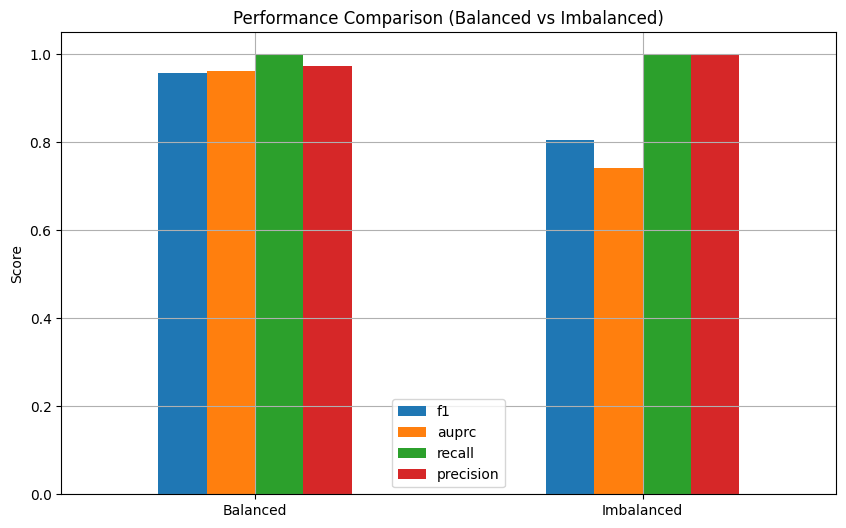

In [13]:
df_results = pd.DataFrame(
    {"Balanced": metrics_bal, "Imbalanced": metrics_imb}
).T.round(4)

display(df_results)

df_results[["f1", "auprc", "recall", "precision"]].plot(
    kind="bar", figsize=(10, 6), grid=True, ylim=(0, 1.05),
    title="Performance Comparison (Balanced vs Imbalanced)"
)
plt.ylabel("Score")
plt.xticks(rotation=0)
plt.show()


In [14]:
h2o.cluster().shutdown(prompt=False)


H2O session _sid_aed0 closed.
